In [ ]:
# default_exp models.esrnn.mqesrnn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# MQESRNN model

> API details.

In [ ]:
# export
from typing import List

from neuralforecast.models.esrnn.esrnn import ESRNN

In [ ]:
# export
class MQESRNN(ESRNN):
    def __init__(self,
                 n_series: int,
                 input_size: int,
                 output_size: int,
                 n_x: int = 0,
                 n_s: int = 0,
                 sample_freq: int = 1,
                 es_component: str = 'median_residual',
                 cell_type: str = 'LSTM',
                 state_hsize: int = 50,
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 add_nl_layer: bool = False,
                 learning_rate: float = 1e-3,
                 lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9,
                 gradient_eps: float = 1e-8,
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0.,
                 noise_std: float = 1e-3,
                 testing_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 training_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 loss: str = 'MQ',
                 val_loss: str = 'MQ',
                 frequency: str = 'D'):
        """ Multi-Quantile Exponential Smoothing Recurrent Neural Network
    
        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentiles: List[float]
            This values are only for diagnostic evaluation.
        training_percentiles: List[float]
            Percentiles to train and forecast.
        loss: str
            Loss used to train.
            Available: 'MQ', 'wMQ'.
        val_loss: str
            Loss used to validate.
            Available: 'MQ', 'wMQ'.
        frequency: str
            Time series frequency.
        
        Notes
        -----
        **References:**
        `Application
        <https://arxiv.org/abs/2112.05673`__
        """
        
        allowed_losses = ['MQ', 'wMQ']
        if loss not in allowed_losses:
            raise Exception(f'Loss {loss} not allowed')
            
        if val_loss is not None and val_loss not in allowed_losses:
            raise Exception(f'Val loss {val_loss} not allowed')
        
        allowed_es_component = ['median_residual', 'identity']
        
        if es_component not in allowed_es_component:
            raise Exception(f'es component {es_component} not allowed')
        
        level_variability_penalty = 0
        seasonality = []
        per_series_lr_multip = 1
        super(MQESRNN, self).__init__(n_series=n_series,
                                      n_s=n_s,
                                      n_x=n_x,
                                      sample_freq=sample_freq,
                                      input_size=input_size,
                                      output_size=output_size,
                                      es_component=es_component,
                                      cell_type=cell_type,
                                      state_hsize=state_hsize,
                                      dilations=dilations,
                                      add_nl_layer=add_nl_layer,
                                      seasonality=seasonality,
                                      learning_rate=learning_rate,
                                      lr_scheduler_step_size=lr_scheduler_step_size,
                                      lr_decay=lr_decay,
                                      per_series_lr_multip=per_series_lr_multip,
                                      gradient_eps=gradient_eps,
                                      gradient_clipping_threshold=gradient_clipping_threshold,
                                      rnn_weight_decay=rnn_weight_decay,
                                      noise_std=noise_std,
                                      level_variability_penalty=level_variability_penalty,
                                      testing_percentile=testing_percentiles,
                                      training_percentile=training_percentiles,
                                      loss=loss,
                                      val_loss=val_loss,
                                      frequency=frequency)

# Tests MQESRNN 

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch as t

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

In [ ]:
n_ds = 100 
n_ts = 1_000

output_size = 10

uids = [f'uid_{i + 1}' for i in range(n_ts)]
dss = pd.date_range(end='2020-01-01', periods=n_ds)

Y_df = pd.DataFrame({'unique_id': np.repeat(uids, n_ds), 'ds': np.tile(dss, n_ts)})

In [ ]:
np.random.seed(10)
Y_df['y'] = Y_df.groupby('unique_id').transform(lambda x: np.random.uniform(1, 100, size=len(x)))

In [ ]:
Y_df = Y_df.sort_values(['unique_id', 'ds'])

In [ ]:
train_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=3*output_size,
                                  is_test=False,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=False)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-12-03 2020-01-01
1           2019-09-24 2019-12-02
INFO:root:
Total data 			100000 time stamps 
Available percentage=100.0, 	100000 time stamps 
Insample  percentage=70.0, 	70000 time stamps 
Outsample percentage=30.0, 	30000 time stamps 

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)


In [ ]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                eq_batch_size=True,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=32,
                                shuffle=False)

In [ ]:
model = MQESRNN(n_series=train_dataset.n_series,
                n_s=train_dataset.n_s,
                n_x=train_dataset.n_x,
                #sample_freq=dataset.sample_freq,
                sample_freq=1,
                input_size=7*2,
                output_size=output_size,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[30, 50, 70, 90],
                training_percentiles=[30, 50, 70, 90],
                es_component='median_residual',
                cell_type='LSTM',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ')

In [ ]:
trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=5, deterministic=True)
trainer.fit(model, train_loader, valid_loader)

/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=5)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | _ESRNN | 292 K 
--------------------

Validation sanity check: 0it [00:00, ?it/s]

/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
outputs = trainer.predict(model, valid_loader)

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This class wraps the pytorch `DataLoader` with a special collate function. If you want to use yours simply use `DataLoader`. Removing collate_fn
  'This class wraps the pytorch `DataLoader` with a '
/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 32it [00:00, ?it/s]

In [ ]:
y_true, y_hat, mask = zip(*outputs)
y_true = t.cat(y_true).numpy()
y_hat = t.cat(y_hat).numpy()
mask = t.cat(mask).numpy()

In [ ]:
y_true = y_true[-1000:, -1]
y_hat = y_hat[-1000:, -1]

calibration p30:  0.3153
calibration p50:  0.4963
calibration p70:  0.6957
calibration p90:  0.9506


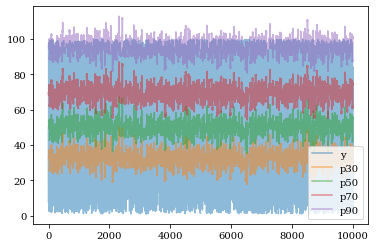

In [ ]:
plt.plot(y_true.flatten(), alpha=0.5, label='y')
for idx, p in enumerate([30, 50, 70, 90]):
    y_p = y_hat[:, :, idx]
    plt.plot(y_p.flatten(), alpha=0.5, label=f'p{p}')
    print(f'calibration p{p}: ', (y_true.flatten() <= y_p.flatten()).mean())
plt.legend()

In [ ]:
forecast = model.forecast(Y_df, batch_size=128)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-09-24 2020-01-01
1           2020-01-02 2020-01-11
INFO:root:
Total data 			110000 time stamps 
Available percentage=100.0, 	110000 time stamps 
Insample  percentage=9.09, 	10000 time stamps 
Outsample percentage=90.91, 	100000 time stamps 

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/Users/fedex/projects/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This clas

Predicting: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='ds'>

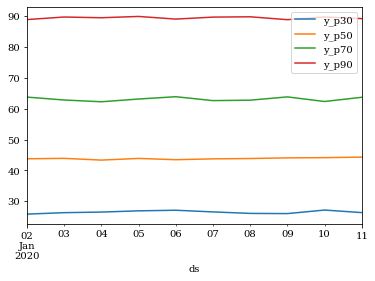

In [ ]:
forecast.query('unique_id == "uid_1"').set_index('ds').plot()